btc static vs dynamic

In [646]:
from IPython.core.pylabtools import figsize
from jupyter_client.session import new_id
%pip install junix

Note: you may need to restart the kernel to use updated packages.


In [647]:
import numpy as np
import pandas as pd
import yfinance as yf
from numpy.ma.core import resize
from scipy.stats import t
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import pyextremes as pyx
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

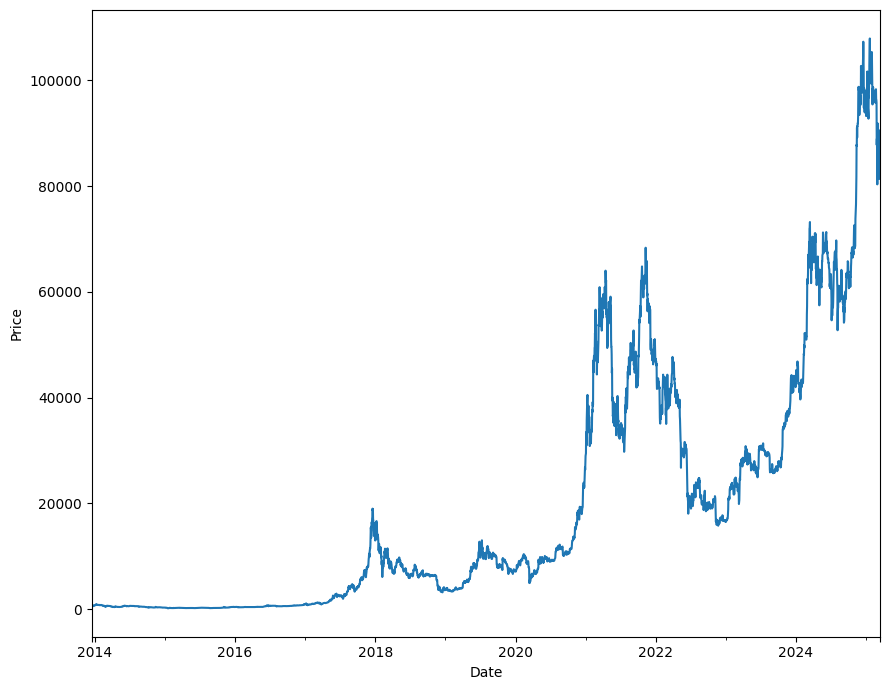

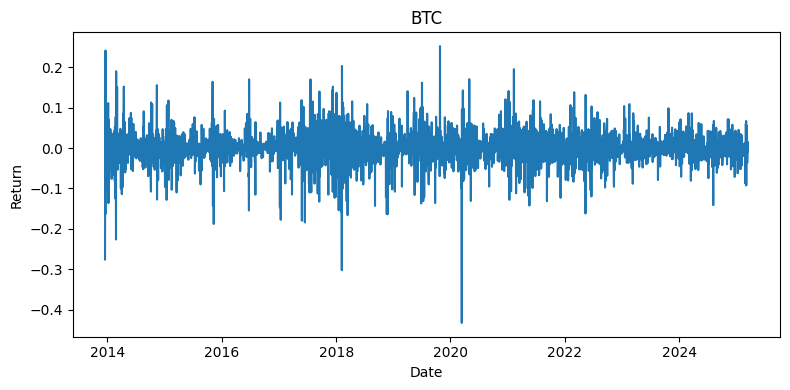

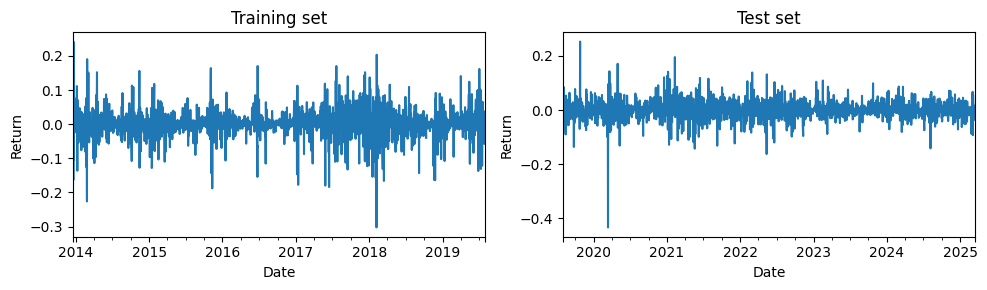

In [648]:
btc_data = pd.read_csv("btc_daily_data.csv")
btc_data.set_index("Date", inplace=True)
btc_data = btc_data['Close'][715:]
btc_data.index = pd.to_datetime(btc_data.index).normalize()
plt.figure(figsize=figsize(9, 7))
btc_data.plot()
plt.ylabel("Price")
plt.tight_layout()
# plt.savefig("btc_daily_price.png")

full_data = np.log(btc_data / btc_data.shift(1)).dropna()
plt.figure(figsize=(8, 4))
plt.plot(full_data)
plt.title("BTC")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
# plt.savefig("log_btc_returns.png")
plt.show()

split = len(full_data) // 2
log_btc_returns = full_data.iloc[:split]
backtest_data = full_data.iloc[split:]

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

log_btc_returns.plot(ax=axs[0])
axs[0].set_title("Training set")
axs[0].set_ylabel("Return")

    # Plot 2
backtest_data.plot(ax=axs[1])
axs[1].set_title("Test set")
axs[1].set_ylabel("Return")

plt.tight_layout()
# plt.savefig("log_btc_returns.png")


In [649]:
def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]

    datas = np.sort(data)[::-1]

    k_values = range(10, len(datas)//4)
    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]

    fig, axs = plt.subplots(3, 1, figsize=(6, 6))

    axs[0].plot(k_values, hill_estimates)
    axs[0].set_title("Hill plots")
    axs[0].set_xlabel("k - number of exceedances")
    axs[0].set_ylabel("Hill estimator")

    # Plot 2
    axs[1].plot(k_values, pickands_estimates, color='green')
    axs[1].set_title("Pickands plots")
    axs[1].set_xlabel("k - number of exceedances")
    axs[1].set_ylabel("Pickands estimator")

    # Plot 3
    pyx.plot_mean_residual_life(data, ax=axs[2])
    axs[2].set_title("Mean Excess plot")
    axs[2].set_xlabel("Threshold")
    axs[2].set_ylabel("Mean excess")

    # Plot 4
    # pyx.plot_parameter_stability(data, ax=axs[1, 1])

    plt.tight_layout()
    # plt.savefig("threshold_picking_plots_dynamic.png")

    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = pyx.EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()
    # plt.savefig("diagnostic_plots_dynamic.png")

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total # probability of exceeding the threshold u
    print("Violation ratio: ", F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)            
    ES = (VaR + (sig - xi * u)) / (1 - xi)
    return -VaR, -ES

0.06653879770463833 0.05617078777076411


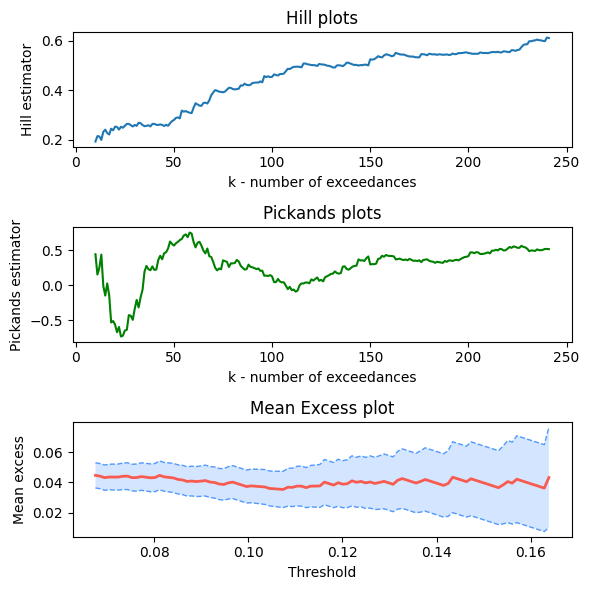

In [650]:
sorted_static_btc = threshold_picking(log_btc_returns)
print(sorted_static_btc[100], sorted_static_btc[130])

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

<Figure size 800x800 with 0 Axes>

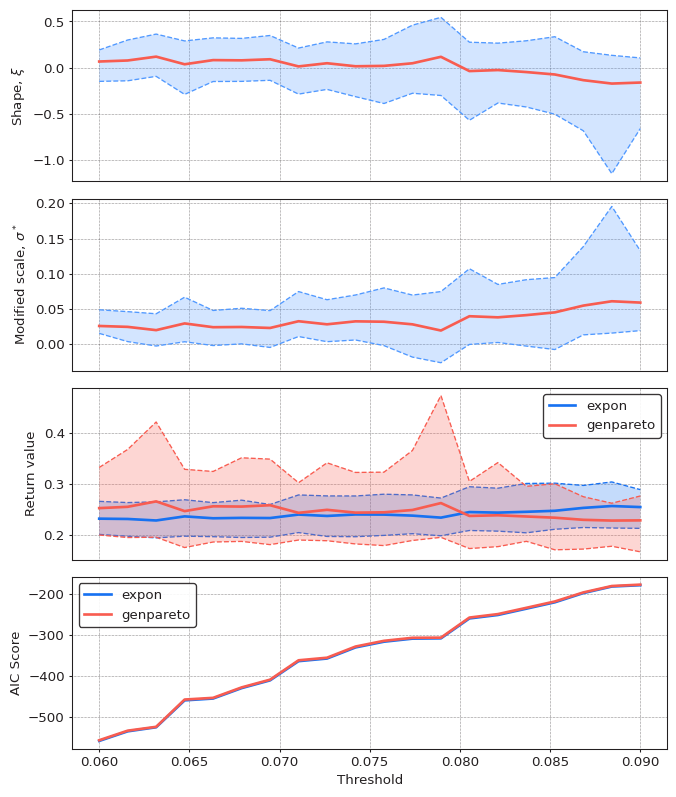

In [651]:
plt.figure(figsize=(8, 8))
pyx.plot_threshold_stability(log_btc_returns, return_period=10, alpha=0.95, thresholds=np.linspace(0.06, 0.09, 20))
# plt.savefig("threshold_stability_static.png")
#u = 0.02

# pyextremes provides a convenience function to put all of the above together. It also adds an
# additional plot - AIC curve indicating relative model performance. The AIC curve should not
# be used as a threshold selection tool because it will always have the same logarithmic shape.
# Instead, it should guide the user as to which model (e.g. GEVD or Exponential) should be preferred
# for a given threshold.
# lower AIC better -> GEV



| Method   | Recommended $k$ | Approx. Threshold |
| -------- |-----------------|-------------------|
| MRL      | -               | up to 0.12        |
| Hill     | 80-120          |                   |
| Pickands | 75-150          |                   |

pick k = 90 -> threshold 0.0715

from threshold stability plot, stable for threshold = 0.0715

### Static EVT Threshold Selection and Model Fitting

This block performs threshold selection and EVT modeling on **log returns of btccoin** using a static (non-GARCH) approach.

---

#### Threshold Selection

```python
u_static_btc = sorted_static_btc[150]


0.07145007042075571
              MLE model               
--------------------------------------
free parameters: c=-0.065, scale=0.048
fixed parameters: floc=0.071          
AIC: -343.743                         
loglikelihood: 173.947                
return value cache size: 0            
fit parameter cache size: 0           
--------------------------------------
{'c': np.float64(-0.06491535751916744), 'scale': np.float64(0.04827614209609163)}
(np.float64(-0.06491535751916744), np.float64(0.04827614209609163))


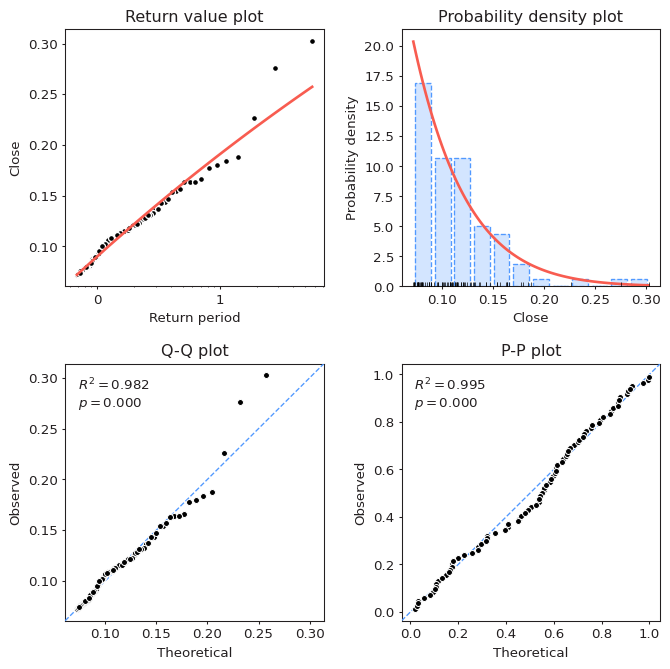

In [652]:
u_static_btc = sorted_static_btc[90]
print(u_static_btc)
params_static_btc = modeling(log_btc_returns, u_static_btc)
print(params_static_btc)

### Static EVT-Based VaR and ES Estimation

This step computes **Value at Risk (VaR)** and **Expected Shortfall (ES)** at the **1% level** using the parameters from the static EVT model.



In [653]:
VaR_static_btc, ES_static_btc = prediction(params_static_btc, log_btc_returns, u_static_btc, level=0.01)
print(f"Static EVT 1% VaR: {-VaR_static_btc:.4f}")
print(f"Static EVT 1% ES : {-ES_static_btc:.4f}")


Violation ratio:  0.043838285435947394
Static EVT 1% VaR: 0.1395
Static EVT 1% ES : 0.1807


### Dynamic approach

1. Fit GARCH(1,1) Model
2. Residual standardization
3. Ljung box test (on residuals and squared residuals)
4. ACF plot of squared residuals

In [654]:
log_btc_returns_dynamic = 100 * log_btc_returns

In [655]:
backtest_data_dynamic = 100 * backtest_data

In [656]:
def create_picture(title, name_x, name_y, name, figsize=(5, 8)):
    # Create a figure with desired size
    plt.figure(figsize=figsize)

    # Plot only conditional volatility
    standardized_resid = results.resid / results.conditional_volatility
    plt.plot(standardized_resid, label=title)
    plt.title(title)
    plt.xlabel(name_x)
    plt.ylabel(name_y)
    plt.legend()

    # Save the figure
    plt.tight_layout()
    plt.savefig(name + ".png")
    plt.show()

Date
2013-12-17   -27.576254
2013-12-18    -2.454786
2013-12-19   -16.385517
2013-12-20    24.205334
2013-12-21   -10.478157
2013-12-22    -4.832193
2013-12-23     7.941646
2013-12-24     2.673898
2013-12-25    -2.494333
2013-12-26     7.364654
Freq: D, Name: Close, dtype: float64
Iteration:      1,   Func. Count:      6,   Neg. LLF: 39693.150235164496
Iteration:      2,   Func. Count:     13,   Neg. LLF: 661991.1867960758
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5960.899268864355
Iteration:      4,   Func. Count:     27,   Neg. LLF: 6595.578161035251
Iteration:      5,   Func. Count:     34,   Neg. LLF: 5560.694036721514
Iteration:      6,   Func. Count:     41,   Neg. LLF: 5510.087311034356
Iteration:      7,   Func. Count:     46,   Neg. LLF: 5509.8655460986165
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5509.820759952185
Iteration:      9,   Func. Count:     56,   Neg. LLF: 5509.815690672696
Iteration:     10,   Func. Count:     61,   Neg. LLF: 5509.815672095

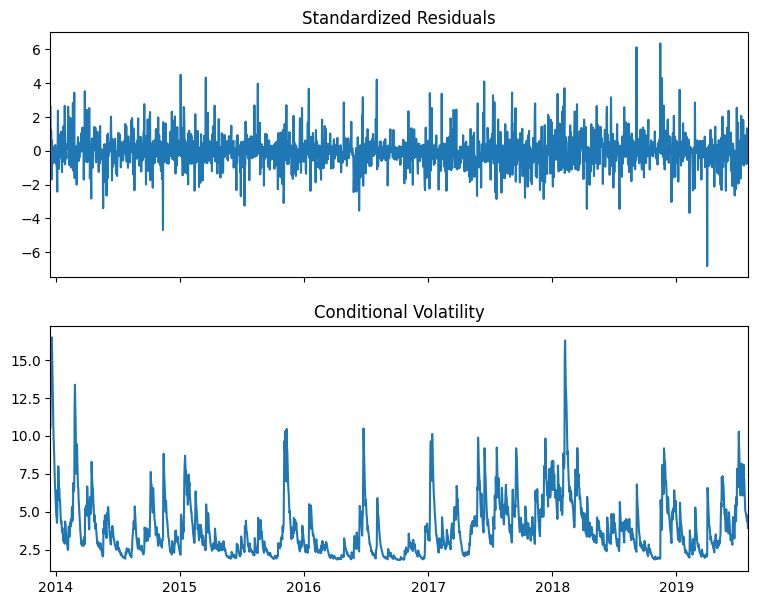

Ljung-Box test on residuals:
      lb_stat  lb_pvalue
1    3.673647   0.055279
2    4.848731   0.088534
3    6.002072   0.111509
4    6.227773   0.182772
5    7.860532   0.164091
6   22.736612   0.000890
7   22.966656   0.001728
8   23.274398   0.003029
9   24.053282   0.004218
10  31.020997   0.000582
Ljung-Box test on squared residuals:
     lb_stat  lb_pvalue
1   0.002131   0.963184
2   1.589812   0.451624
3   1.865334   0.600822
4   2.577493   0.630815
5   4.198854   0.521156
6   4.247102   0.643276
7   4.364048   0.737020
8   4.370894   0.822206
9   4.992419   0.834969
10  7.367881   0.690318
Model is adequate (no remaining ARCH effects at 5% level).


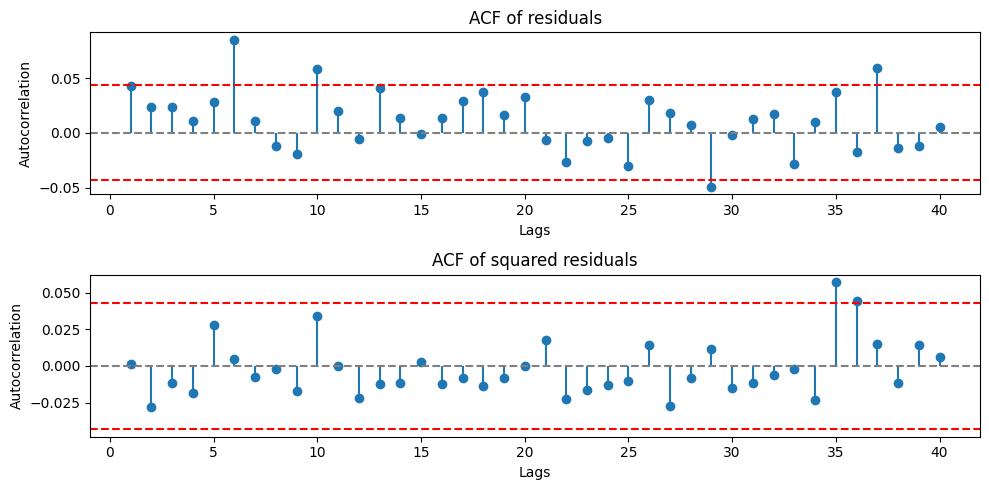

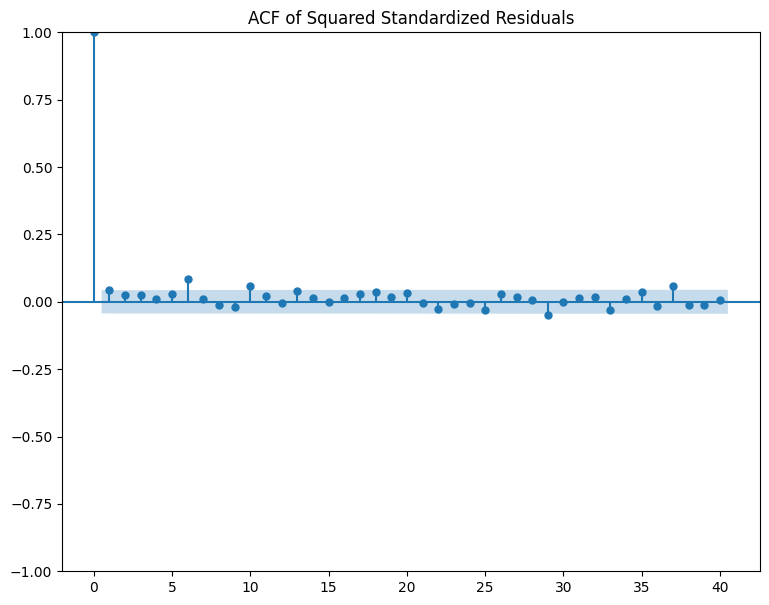

In [657]:
# Two-step process: Fit GARCH(1,1) model, use EVT
print(log_btc_returns_dynamic[:10])
btc_model = arch_model(-log_btc_returns_dynamic, vol='Garch', p=1, q=1, mean="Constant") # removed * 10
results = btc_model.fit()
print(results.summary())
results.plot()
plt.show()
# create_picture(None, None, None, "std_residuals_btc", figsize=(8, 5))


standardized_resid = results.resid / results.conditional_volatility

# Ljung-Box test (lag 1 as example)
ljung_box = acorr_ljungbox(standardized_resid, lags=10, return_df=True)
print("Ljung-Box test on residuals:")
print(ljung_box)

squared_resid = standardized_resid**2
lb_test_squared = acorr_ljungbox(squared_resid, lags=10, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared)

if lb_test_squared["lb_pvalue"].iloc[0] > 0.05:
    print("Model is adequate (no remaining ARCH effects at 5% level).")
else:
    print("Model is inadequate (try EGARCH or higher-order GARCH).")

# Step 3: Plot ACF
acf_vals, confint = acf(standardized_resid, nlags=40, alpha=0.05, fft=True)

# Exclude lag 0
lags = np.arange(1, 41)
acf_nozero = acf_vals[1:]

# Compute confidence level (symmetric)
# Centered around 0 since ACF under null is assumed to be zero
conf_level = 1.96 / np.sqrt(len(standardized_resid))  # 95% CI for white noise

# Plot

fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].set_title("ACF of residuals")
axs[0].set_xlabel("Lags")
axs[0].set_ylabel("Autocorrelation")

axs[0].stem(lags, acf_nozero, basefmt=" ")
axs[0].axhline(y=0, linestyle="--", color="gray")
axs[0].axhline(y=conf_level, linestyle="--", color="red", label="95% CI")
axs[0].axhline(y=-conf_level, linestyle="--", color="red")

# plt.title("ACF of return plot")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")
# plt.tight_layout()

acf_vals, confint = acf(squared_resid, nlags=40, alpha=0.05, fft=True)

# Exclude lag 0
lags = np.arange(1, 41)
acf_nozero = acf_vals[1:]

# Compute confidence level (symmetric)
# Centered around 0 since ACF under null is assumed to be zero
conf_level = 1.96 / np.sqrt(len(squared_resid))  # 95% CI for white noise

axs[1].set_title("ACF of squared residuals")
axs[1].set_xlabel("Lags")
axs[1].set_ylabel("Autocorrelation")

axs[1].stem(lags, acf_nozero, basefmt=" ")
axs[1].axhline(y=0, linestyle="--", color="gray")
axs[1].axhline(y=conf_level, linestyle="--", color="red", label="95% CI")
axs[1].axhline(y=-conf_level, linestyle="--", color="red")

plt.tight_layout()
# plt.savefig("ACF.png")

# plt.savefig("acf_squared_return_plot.png")
plt.show()
sm.graphics.tsa.plot_acf(standardized_resid, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

shock at around 2021

check the time series notes on ACF to access the garch (look into 25 lag)

1.4017544589367446


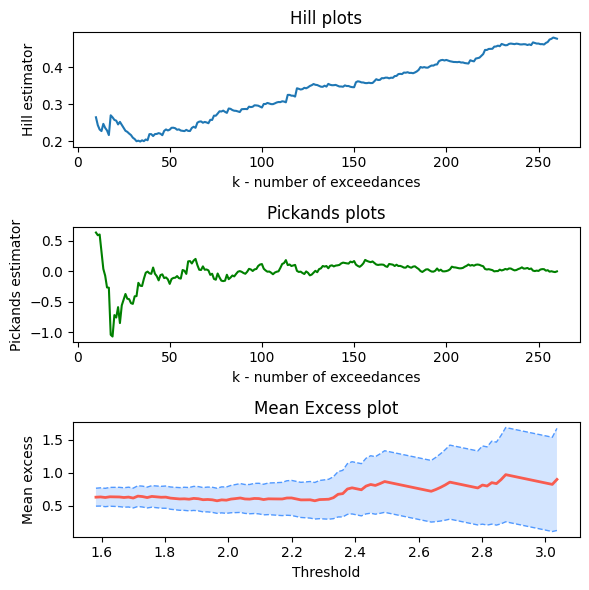

In [658]:
sorted_dynamic_btc = threshold_picking(standardized_resid)
print(sorted_dynamic_btc[130])

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

<Figure size 800x800 with 0 Axes>

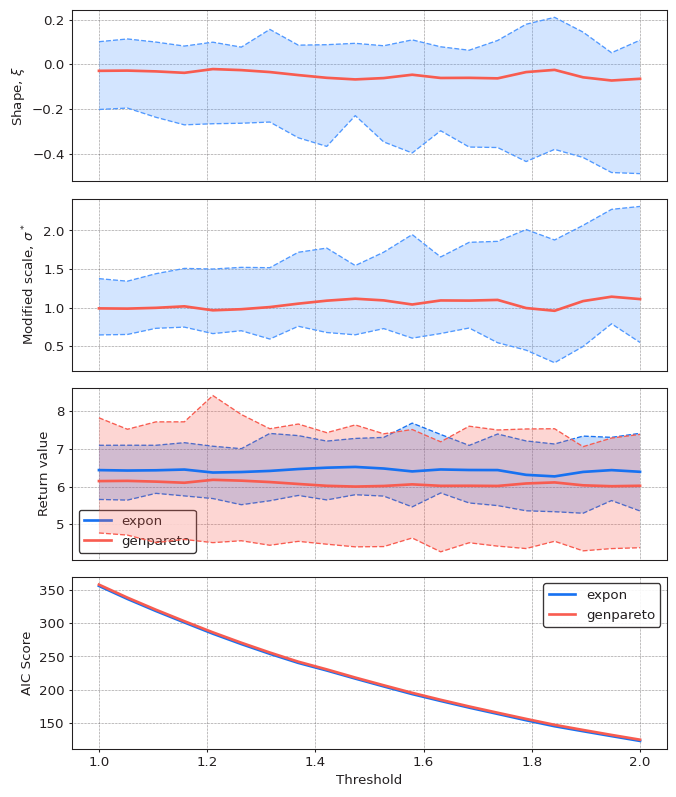

In [659]:
plt.figure(figsize=(8, 8))
pyx.plot_threshold_stability(standardized_resid, return_period=10, alpha=0.95, thresholds=np.linspace(1, 2.0, 20))
# plt.savefig("threshold_stability_dynamic.png")

| Method   | Recommended $k$ | Approx. Threshold |
| -------- | --------------- | ----------------- |
| MRL      | -               | 1.5-1.8        |
| Hill     | 125-175         |                   |
| Pickands | 125-200        |                   |

pick k = 130 -> threshold 1.4017544589367446

from threshold stability plot, stable for threshold = 1.4017544589367446

threshold for dynamic: 1.4017544589367446
              MLE model              
-------------------------------------
free parameters: c=0.005, scale=0.708
fixed parameters: floc=1.402         
AIC: 157.029                         
loglikelihood: -76.461               
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': np.float64(0.005116895023597764), 'scale': np.float64(0.707557281560071)}
(np.float64(0.005116895023597764), np.float64(0.707557281560071))


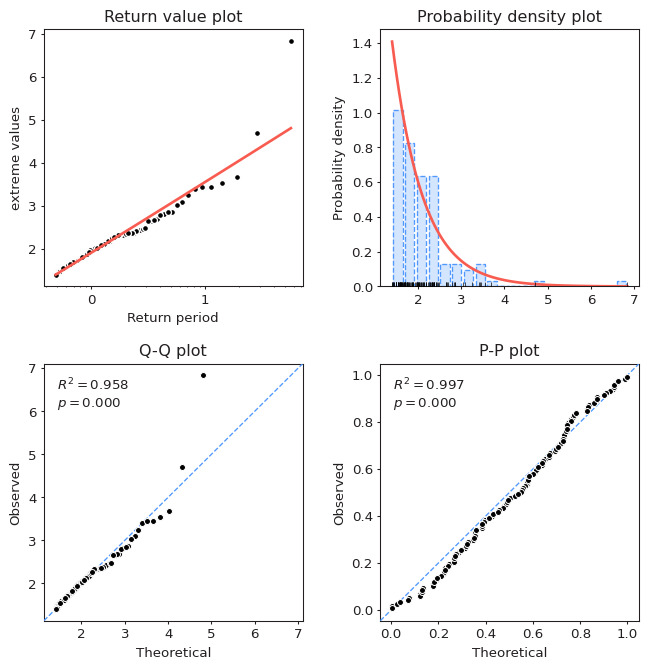

In [660]:
u_dynamic_btc = sorted_dynamic_btc[130]
#u_dynamic_btc = np.searchsorted(sorted_dynamic_btc, 2.25, side="left")
print(f"threshold for dynamic: {u_dynamic_btc}")
params_dynamic_btc = modeling(standardized_resid, u_dynamic_btc)
print(params_dynamic_btc)

In [661]:
VaR_dynamic_btc, ES_dynamic_btc = prediction(params_dynamic_btc, standardized_resid, u_dynamic_btc, 0.01)
VaR_return = VaR_dynamic_btc * results.conditional_volatility

# Print selected thresholds
print("\n Thresholds Used:")
print(f"Static EVT Threshold (u_static_btc):  {u_static_btc:.4f}")
print(f"Dynamic EVT Threshold (u_dynamic_btc): {u_dynamic_btc:.4f}")

# Print dynamic EVT results
print("\n Dynamic EVT 1% VaR (on return scale):")
print(VaR_return.describe())

print(f"\n Dynamic EVT 1% Expected Shortfall (ES): {ES_dynamic_btc:.4f}")

# Print static EVT results
print(f"\n Static EVT Results (based on raw log returns):")
print(f"Static EVT 1% VaR: {VaR_static_btc:.4f}")
print(f"Static EVT 1% ES : {ES_static_btc:.4f}")

Violation ratio:  0.06332196785192401

 Thresholds Used:
Static EVT Threshold (u_static_btc):  0.0715
Dynamic EVT Threshold (u_dynamic_btc): 1.4018

 Dynamic EVT 1% VaR (on return scale):
count    2053.000000
mean      -10.612691
std         5.316555
min       -44.792596
25%       -12.748024
50%        -9.123004
75%        -6.837516
max        -4.884012
Name: cond_vol, dtype: float64

 Dynamic EVT 1% Expected Shortfall (ES): -3.4318

 Static EVT Results (based on raw log returns):
Static EVT 1% VaR: -0.1395
Static EVT 1% ES : -0.1807


Unconditional, Conditional coverage test

In [662]:
from scipy.stats import chi2

def unconditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    violations = (actual_returns < var_forecast).astype(int) #indicator function
    V = np.sum(violations) # No. of violations
    p = len(actual_returns) # Total observations
    k = V/p

    LR_statistic = -2 * np.log(k**V*(1-k)**(p-V)/(1-alpha)**V*alpha**(p-V))

    p_value = 1 - chi2.cdf(LR_statistic, df=1)

    reject_null = p_value < 0.05

    return LR_statistic, p_value, reject_null

def conditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    # Unconditional Coverage (UC) Test
    actual_returns = np.asarray(actual_returns).flatten()
    var_forecast = np.asarray(var_forecast).flatten()
    
    min_length = min(len(actual_returns), len(var_forecast))
    actual_returns = actual_returns[:min_length]
    var_forecast = var_forecast[:min_length]

    violations = (actual_returns < var_forecast).astype(int) 
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    print(V, n, p_uc)
    #print(actual_returns.head(), var_forecast, p_uc)
    LR_uc = -2 * np.log((alpha**V * (1 - alpha)**(n - V))) + 2 * np.log((p_uc**V * (1 - p_uc)**(n - V)))
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n / alpha,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

print(results.conditional_volatility.head())
print(results.resid.head())
# print(conditional_coverage_test(log_btc_returns, VaR_return, alpha=0.01)) # this should be untouched data, alpha = 0.01
# # VaR dynamic btc is standardized, so we need to convert it back to original scale


Date
2013-12-17    10.554442
2013-12-18    15.473272
2013-12-19    13.710111
2013-12-20    14.165326
2013-12-21    16.505236
Freq: D, Name: cond_vol, dtype: float64
Date
2013-12-17    27.654126
2013-12-18     2.532659
2013-12-19    16.463389
2013-12-20   -24.127462
2013-12-21    10.556029
Freq: D, Name: resid, dtype: float64


In [663]:
# Run conditional coverage tests for dynamic and static models

def fixed_window_forecasting():
    omega = results.params['omega']
    alpha = results.params['alpha[1]']
    beta = results.params['beta[1]']
    sigma_t = results.conditional_volatility.iloc[-1]
    r_t = log_btc_returns_dynamic.iloc[-1]
    print(omega, alpha, beta, sigma_t, r_t)

    VaR_estimates = []
    for i in range(len(backtest_data_dynamic)):
        sigma_next = (omega + alpha * r_t ** 2 + beta * sigma_t ** 2) ** 0.5
        VaR_estimates.append(sigma_next * VaR_dynamic_btc)
        r_t = backtest_data_dynamic.iloc[i]
        sigma_t = sigma_next
    print(VaR_dynamic_btc)
    print(VaR_estimates[:10])
    return VaR_estimates

backtest_VaR_estimates_fixed = fixed_window_forecasting()
cc_dynamic_backtest_fixed = conditional_coverage_test(backtest_data_dynamic, backtest_VaR_estimates_fixed, alpha=0.01)



0.6945536660086468 0.19900465541556878 0.7768541909586008 3.9274197843256915 2.512761858677558
-2.71384150019236
[np.float64(-10.130210524184806), np.float64(-9.552890233453686), np.float64(-10.868508010235313), np.float64(-10.594653180542416), np.float64(-9.846695937162593), np.float64(-13.679653524526728), np.float64(-12.535719287354793), np.float64(-11.494485522991654), np.float64(-10.954481223675174), np.float64(-9.955735500219342)]
19 2053 0.009254749147588894


In [664]:
cc_dynamic = conditional_coverage_test(log_btc_returns_dynamic, VaR_return, alpha=0.01)
cc_static = conditional_coverage_test(log_btc_returns, np.full_like(log_btc_returns, VaR_static_btc), alpha=0.01)
cc_dynamic_backtest_fixed = conditional_coverage_test(backtest_data_dynamic, backtest_VaR_estimates_fixed, alpha=0.01)
# cc_dynamic_backtest_rolling = conditional_coverage_test(backtest_data, backtest_VaR_estimates_rolling, alpha=0.01)
cc_static_backtest = conditional_coverage_test(backtest_data, np.full_like(backtest_data, VaR_static_btc), alpha=0.01)

cc_table_in_sample = pd.DataFrame({
    "Statistic": [
        "LR_UC", "p-value_UC", "Reject_UC?",
        "LR_IND", "p-value_IND", "Reject_IND?",
        "LR_CC", "p-value_CC", "Reject_CC?",
        "Violation Rate", "Expected Rate"
    ],
    "Dynamic EVT (In-sample)": [
        cc_dynamic["LR_UC"], cc_dynamic["p-value_UC"], cc_dynamic["Reject_UC?"],
        cc_dynamic["LR_IND"], cc_dynamic["p-value_IND"], cc_dynamic["Reject_IND?"],
        cc_dynamic["LR_CC"], cc_dynamic["p-value_CC"], cc_dynamic["Reject_CC?"],
        cc_dynamic["Violation Rate"], cc_dynamic["Expected Rate"]
    ],
    "Static EVT (In-sample)": [
        cc_static["LR_UC"], cc_static["p-value_UC"], cc_static["Reject_UC?"],
        cc_static["LR_IND"], cc_static["p-value_IND"], cc_static["Reject_IND?"],
        cc_static["LR_CC"], cc_static["p-value_CC"], cc_static["Reject_CC?"],
        cc_static["Violation Rate"], cc_static["Expected Rate"]
    ]
})

cc_table_backtest_sample = pd.DataFrame({
    "Statistic": [
        "LR_UC", "p-value_UC", "Reject_UC?",
        "LR_IND", "p-value_IND", "Reject_IND?",
        "LR_CC", "p-value_CC", "Reject_CC?",
        "Violation Rate", "Expected Rate"
    ],
    # "Dynamic EVT (Backtest Rolling)": [
    #     cc_dynamic_backtest_rolling["LR_UC"], cc_dynamic_backtest_rolling["p-value_UC"], cc_dynamic_backtest_rolling["Reject_UC?"],
    #     cc_dynamic_backtest_rolling["LR_IND"], cc_dynamic_backtest_rolling["p-value_IND"], cc_dynamic_backtest_rolling["Reject_IND?"],
    #     cc_dynamic_backtest_rolling["LR_CC"], cc_dynamic_backtest_rolling["p-value_CC"], cc_dynamic_backtest_rolling["Reject_CC?"],
    #     cc_dynamic_backtest_rolling["Violation Rate"], cc_dynamic_backtest_rolling["Expected Rate"]
    # ],
    "Dynamic EVT (Backtest Fixed)": [
        cc_dynamic_backtest_fixed["LR_UC"], cc_dynamic_backtest_fixed["p-value_UC"], cc_dynamic_backtest_fixed["Reject_UC?"],
        cc_dynamic_backtest_fixed["LR_IND"], cc_dynamic_backtest_fixed["p-value_IND"], cc_dynamic_backtest_fixed["Reject_IND?"],
        cc_dynamic_backtest_fixed["LR_CC"], cc_dynamic_backtest_fixed["p-value_CC"], cc_dynamic_backtest_fixed["Reject_CC?"],
        cc_dynamic_backtest_fixed["Violation Rate"], cc_dynamic_backtest_fixed["Expected Rate"]
    ],
    "Static EVT (Backtest)": [
        cc_static_backtest["LR_UC"], cc_static_backtest["p-value_UC"], cc_static_backtest["Reject_UC?"],
        cc_static_backtest["LR_IND"], cc_static_backtest["p-value_IND"], cc_static_backtest["Reject_IND?"],
        cc_static_backtest["LR_CC"], cc_static_backtest["p-value_CC"], cc_static_backtest["Reject_CC?"],
        cc_static_backtest["Violation Rate"], cc_static_backtest["Expected Rate"]
    ]
})

# Combine all tables for display
cc_table_final = pd.merge(cc_table_in_sample, cc_table_backtest_sample, on="Statistic")

# Display the comprehensive comparison table
display(cc_table_final)
print("Static threshold: ", u_static_btc, "  Dynamic threshold: ", u_dynamic_btc)

28 2053 0.013638577691183634
18 2053 0.00876765708718948
19 2053 0.009254749147588894
4 2053 0.001948368241597662


,Statistic,Dynamic EVT (In-sample),Static EVT (In-sample),Dynamic EVT (Backtest Fixed),Static EVT (Backtest)
0,LR_UC,2.465256,0.328591,0.118118,20.109332
1,p-value_UC,0.116389,0.56649,0.731085,0.000007
2,Reject_UC?,False,False,False,True
3,LR_IND,0.774728,2.189499,0.355145,0.015625
4,p-value_IND,0.378758,0.138954,0.551215,0.900524
5,Reject_IND?,False,False,False,False
6,LR_CC,3.239984,2.51809,0.473263,20.124957
7,p-value_CC,0.1979,0.283925,0.789282,0.000043
8,Reject_CC?,False,False,False,True
9,Violation Rate,1.363858,0.876766,0.925475,0.194837


Static threshold:  0.07145007042075571   Dynamic threshold:  1.4017544589367446


Both models pass the backtests â€” they do not violate unconditional, independence, or conditional coverage assumptions at the 1% level.
However, the Dynamic EVT model performs better statistically and practically.

Why Dynamic EVT is Better
Closer match to violation rate (1.0036% vs. 0.9558%)

Higher p-values across all tests (i.e., stronger evidence of model adequacy)

Smaller likelihood ratios, indicating better model fit

Incorporates time-varying volatility via GARCH, making it more adaptive to market conditions

This tells you how often you expect certain extreme returns to happen, based on your model. 

In [665]:
print(f"stand_resid: {standardized_resid}")

extremes = pyx.get_extremes(
    ts=standardized_resid,
    method="POT",
    threshold = 0.12
)
return_periods = pyx.get_return_periods(
    ts=standardized_resid,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    return_period_size="365.2425D",
    plotting_position="weibull",
)
return_periods.sort_values("return period", ascending=False).head()

stand_resid: Date
2013-12-17    2.620141
2013-12-18    0.163680
2013-12-19    1.200821
2013-12-20   -1.703276
2013-12-21    0.639556
                ...   
2019-07-27   -0.777734
2019-07-28    1.328808
2019-07-29   -0.194000
2019-07-30    0.353046
2019-07-31   -0.619972
Freq: D, Length: 2053, dtype: float64


,extreme values,exceedance probability,return period
Date,,,
2018-11-15,6.357999,0.001894,5.628846
2018-09-06,6.129694,0.003788,2.814423
2015-01-04,4.500782,0.005682,1.876282
2015-03-19,4.327304,0.007576,1.407211
2018-11-20,4.310888,0.009470,1.125769


Trying out to fit ARMA first to get better results for BTC

/Users/danylodubas/Documents/Coding/ExtremeValueTheory/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/danylodubas/Documents/Coding/ExtremeValueTheory/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/danylodubas/Documents/Coding/ExtremeValueTheory/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2053
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1131.820
Date:                Tue, 10 Jun 2025   AIC                           2271.641
Time:                        12:43:16   BIC                           2294.149
Sample:                    12-17-2013   HQIC                          2279.894
                         - 07-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.009      1.345      0.179      -0.005       0.029
ar.L1          0.1808      0.203      0.891      0.373      -0.217       0.579
ma.L1         -0.2493      0.199     -1.255      0.2

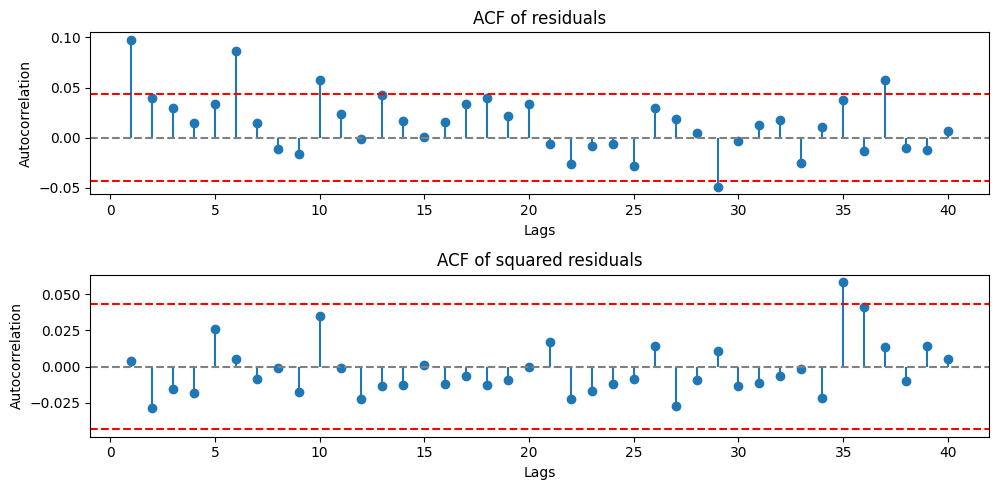

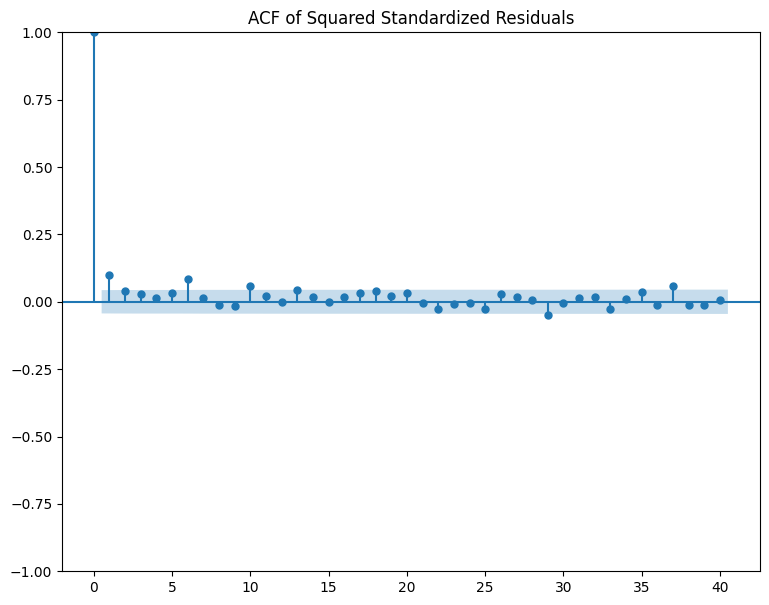

In [666]:
# log_btc_returns_dynamic
# backtest_data_dynamic

from statsmodels.tsa.arima.model import ARIMA
new_data = log_btc_returns
arma_model = ARIMA(new_data * 10, order=(1,0,1))
arma_res = arma_model.fit()

print(arma_res.summary())

# Get residuals from ARMA
resid = arma_res.resid

# Fit GARCH(1,1) on ARMA residuals
garch = arch_model(resid, vol='Garch', p=1, q=1)
garch_res = garch.fit()

print(garch_res.summary())

garch_residuals = garch_res.resid / garch_res.conditional_volatility

# Step 3: Plot ACF
acf_vals, confint = acf(garch_residuals, nlags=40, alpha=0.05, fft=True)

# Exclude lag 0
lags = np.arange(1, 41)
acf_nozero = acf_vals[1:]

# Compute confidence level (symmetric)
# Centered around 0 since ACF under null is assumed to be zero
conf_level = 1.96 / np.sqrt(len(garch_residuals))  # 95% CI for white noise

# Plot

fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].set_title("ACF of residuals")
axs[0].set_xlabel("Lags")
axs[0].set_ylabel("Autocorrelation")

axs[0].stem(lags, acf_nozero, basefmt=" ")
axs[0].axhline(y=0, linestyle="--", color="gray")
axs[0].axhline(y=conf_level, linestyle="--", color="red", label="95% CI")
axs[0].axhline(y=-conf_level, linestyle="--", color="red")

acf_vals, confint = acf(garch_residuals ** 2, nlags=40, alpha=0.05, fft=True)
# Exclude lag 0
lags = np.arange(1, 41)
acf_nozero = acf_vals[1:]
# Compute confidence level (symmetric)
# Centered around 0 since ACF under null is assumed to be zero
conf_level = 1.96 / np.sqrt(len(garch_residuals))  # 95% CI for white noise
axs[1].set_title("ACF of squared residuals")
axs[1].set_xlabel("Lags")
axs[1].set_ylabel("Autocorrelation")
axs[1].stem(lags, acf_nozero, basefmt=" ")
axs[1].axhline(y=0, linestyle="--", color="gray")
axs[1].axhline(y=conf_level, linestyle="--", color="red", label="95% CI")
axs[1].axhline(y=-conf_level, linestyle="--", color="red")
plt.tight_layout()
# plt.savefig("ACF.png")

# plt.savefig("acf_squared_return_plot.png")
plt.show()
sm.graphics.tsa.plot_acf(garch_residuals, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

In [521]:
print(res.params)

Const       0.080011
Close[1]   -0.006366
omega       0.683260
alpha[1]    0.198146
beta[1]     0.778886
Name: params, dtype: float64


In [ ]:
alpha = res.params[1]
beta = res.params[2]
new_data = [ for i in range(1, len(new_data))]